#### Question 1

In [ ]:
import copy
import math
import os
from collections import namedtuple
import gym
import ipywidgets as widgets
import matplotlib.pyplot as plt
import more_itertools as mitt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.init as init
import tqdm

#### Parts a, b, c

In [2]:
input=np.linspace(-10, 10, 500)
input=torch.Tensor([input])
input=torch.t(input)

def F(x):
  y=x**2+1
  return y
output=F(input)

dataset=torch.column_stack((input,output))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  


In [3]:

class MLP(nn.Module):
    
    def __init__(self, input_dim=1, num_layers=3, hidden_dim=8,output_dim=1):
        """
        MLP Model
        """
        super(MLP, self).__init__()
        self.input_dim = input_dim
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        
        layer_map = []
        layer_map.append(nn.Linear(self.input_dim,self.hidden_dim)) # input layer
        layer_map.append(nn.ReLU())


        for i in range(2,num_layers):
            layer_map.append(nn.Linear(self.hidden_dim,self.hidden_dim))
            layer_map.append(nn.ReLU())
            
        layer_map.append(nn.Linear(self.hidden_dim,1)) # output layer
        layer_map.append(nn.Identity())  ####???
        
        self.model = nn.Sequential(*layer_map)

   


    def forward(self, inputs) -> torch.Tensor:
        """
        Forward function

        """

        return self.model(inputs)

In [4]:
def train_MLP_batch(optimizer, batch, MLP_model) -> float:
    """Perform a single batch-update step on the given MLP model.

    """
 
    inputs= batch[:,0]
    labls=batch[:,1].reshape(*batch[:,1].shape,1)
    outputs = MLP_model(inputs.reshape(*inputs.shape,1))

    # computing the scalar MSE loss between computed labls and the outputs
    loss = nn.functional.mse_loss(outputs, labls)

    optimizer.zero_grad()  # reset all previous gradients
    loss.backward()  # compute new gradients
    optimizer.step()  # perform one gradient descent step

    return loss.item()

In [5]:
def train_MLP(
    
    input_dim,
    num_layers,
    hidden_dim,
    output_dim,
    batch_size ,
    num_episods,
    dataset,
):

    # initialize the MLP
    MLP_model = MLP(input_dim=input_dim, num_layers=num_layers, hidden_dim=hidden_dim, output_dim=output_dim)
   
    # initialize the optimizer
    optimizer = torch.optim.Adam(MLP_model.parameters())
    episods = tqdm.notebook.tnrange(num_episods)
    losses=torch.zeros(num_episods)

    for i in episods:

        
        inputs_size=dataset.shape[0]

        num_batches = math.ceil(inputs_size/batch_size)
        batch_list = [dataset[batch_size*y:batch_size*(y+1),:] for y in range(num_batches)]

        jj=1

        for j in range(num_batches):  
            
            loss = train_MLP_batch(optimizer, batch_list[j], MLP_model)

            episods.set_description(
                f'Episode: {i} | Batch_number: {j} | Batch_loss: {loss:5.2f} | Hidden_dim: {hidden_dim:5.2g}'
            )


        losses[i]=loss

    trained_models=MLP_model
    trained_models = copy.deepcopy(MLP_model)

    return (
        trained_models,
        losses,
    )

In [6]:
input=np.linspace(-10, 10, 500)
input=torch.Tensor([input])
input=torch.t(input)

def F(x):
  y=x**2+1
  return y
output=F(input)

dataset=torch.column_stack((input,output))

In [14]:
input_dim=1
num_layers=3
output_dim=1
batch_size = 32
num_episods=100
hidden_dims=[8,16,64,128]

losses_list=torch.zeros(len(hidden_dims),num_episods)
jj=0

for i in hidden_dims:

  r=torch.randperm(dataset.shape[0])
  dataset=dataset[r]

  trained_model, losses = train_MLP(
      input_dim= input_dim,
      num_layers= num_layers,
      hidden_dim= hidden_dims[jj],
      output_dim= output_dim,
      batch_size = batch_size,
      num_episods= num_episods,
      dataset=dataset,
  )
  print(losses)
  losses_list[jj,:]=losses
  jj+=1
  

  0%|          | 0/100 [00:00<?, ?it/s]

tensor([1192.3900, 1185.8303, 1179.5247, 1172.7976, 1164.6511, 1154.6555,
        1142.5486, 1127.5386, 1109.3850, 1087.7662, 1060.8977, 1030.3948,
         996.6107,  959.9368,  920.6774,  879.3117,  836.0303,  790.8494,
         743.9437,  695.7986,  647.1227,  598.7248,  551.4069,  505.8838,
         462.7287,  422.3683,  385.0954,  351.1049,  320.5331,  293.4418,
         269.8627,  249.7775,  233.1094,  219.6852,  209.2546,  201.4969,
         196.0385,  192.4737,  190.3940,  189.4133,  189.1851,  189.4187,
         189.8888,  190.4214,  190.9043,  191.2637,  191.4617,  191.4840,
         191.3334,  191.0218,  190.5665,  189.9871,  189.3032,  188.5335,
         187.6951,  186.8010,  185.8624,  184.8894,  183.8901,  182.8708,
         181.8366,  180.7915,  179.7399,  178.6835,  177.6257,  176.5670,
         175.5087,  174.4513,  173.3957,  172.3422,  171.2915,  170.2436,
         169.1988,  168.1575,  167.1197,  166.0856,  165.0553,  164.0284,
         163.0063,  161.9881,  160.973

  0%|          | 0/100 [00:00<?, ?it/s]

tensor([2724.0894, 2626.8379, 2518.1909, 2395.8647, 2254.3254, 2094.1624,
        1919.4733, 1738.3865, 1561.9177, 1400.9742, 1258.1575, 1137.7061,
        1035.7073,  943.7837,  855.9435,  769.5615,  684.4686,  601.7955,
         523.2802,  450.7943,  386.0431,  330.2721,  284.0802,  247.3473,
         219.2931,  198.6516,  183.9207,  173.6065,  166.4036,  161.2837,
         157.5070,  154.5798,  152.1737,  150.0917,  148.2105,  146.4485,
         144.7668,  143.1696,  141.6048,  140.0698,  138.5637,  137.0747,
         135.5986,  134.1319,  132.6778,  131.2319,  129.7859,  128.3512,
         126.9217,  125.5004,  124.0867,  122.6799,  121.2683,  119.8710,
         118.4771,  117.0881,  115.7106,  114.3230,  112.9357,  111.5618,
         110.1513,  108.7447,  107.3619,  106.0015,  104.6251,  103.2594,
         101.8883,  100.5283,   99.1331,   97.7350,   96.1971,   94.6031,
          92.9467,   91.3448,   89.7753,   88.2369,   86.6268,   85.1321,
          83.3854,   81.7313,   80.210

  0%|          | 0/100 [00:00<?, ?it/s]

tensor([1648.7008, 1332.1963,  889.2394,  444.6171,  178.1600,  124.1582,
         124.5686,  122.7494,  120.1453,  116.4590,  112.8424,  109.8575,
         107.1735,  104.5055,  101.7641,   98.9483,   96.2858,   93.6575,
          91.0095,   88.3562,   85.7109,   83.0640,   80.4118,   77.7569,
          75.0991,   72.4383,   69.7792,   67.1257,   64.4768,   61.8425,
          59.2221,   56.6295,   54.0868,   51.5711,   49.0757,   46.5741,
          44.0689,   41.5648,   39.4332,   37.4409,   35.5926,   33.8709,
          32.2769,   30.7431,   29.2336,   27.8541,   26.7880,   25.8116,
          24.9684,   24.1553,   23.4361,   22.7416,   22.1495,   21.5226,
          20.9308,   20.3455,   19.7672,   19.2017,   18.7100,   18.3059,
          17.8171,   17.3960,   16.9966,   16.5755,   16.1567,   15.7602,
          15.3583,   14.9681,   14.5703,   14.1693,   13.8106,   13.4121,
          13.0600,   12.6981,   12.3024,   11.9883,   11.6019,   11.2847,
          10.9304,   10.5781,   10.265

  0%|          | 0/100 [00:00<?, ?it/s]

tensor([2028.4232,  939.0112,  216.2316,  144.3701,  148.7468,  151.1740,
         140.0165,  136.2669,  133.3539,  128.6245,  124.2481,  120.0418,
         115.5972,  111.1500,  106.6341,  102.0646,   97.4440,   92.7742,
          88.0704,   83.3468,   78.5850,   73.4804,   68.8018,   63.9418,
          59.6541,   55.3456,   51.3562,   47.4809,   44.0901,   41.1186,
          38.4512,   36.1077,   34.0803,   32.2440,   30.6999,   29.3193,
          28.0811,   26.9145,   25.8686,   24.8830,   24.0802,   23.2692,
          22.5741,   21.8603,   21.2207,   20.5624,   20.0026,   19.4060,
          18.8399,   18.2640,   17.7665,   17.2043,   16.6895,   16.1502,
          15.7391,   15.1890,   14.7446,   14.5971,   13.9495,   13.3613,
          13.0372,   12.6029,   12.0738,   11.7612,   11.3255,   10.8712,
          10.5205,   10.1275,    9.7340,    9.3811,    9.0014,    8.6065,
           8.3130,    7.9792,    7.5896,    7.3091,    6.9755,    6.6948,
           6.4639,    6.2024,    5.935

#### part d

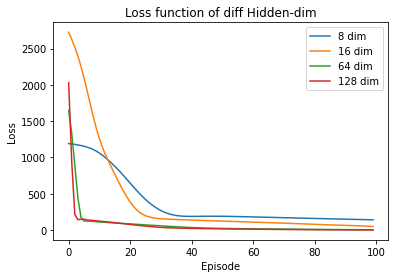

In [18]:
  plt.plot(losses_list[0],label="8 dim")
  plt.plot(losses_list[1],label="16 dim")
  plt.plot(losses_list[2],label="64 dim")
  plt.plot(losses_list[3],label="128 dim")
  plt.title("Loss function of diff Hidden-dim")
  plt.xlabel("Episode")
  plt.ylabel("Loss")
  plt.legend()
  plt.show()


#### Part e

#### As it is obvious the larger dimension the more accurate model, because with increasing the dimension the predictiong model will be more complex and it would be able to model most features of the function

In [44]:
output_of_NN=trained_model(input)
output_of_NN=output_of_NN.detach().numpy()

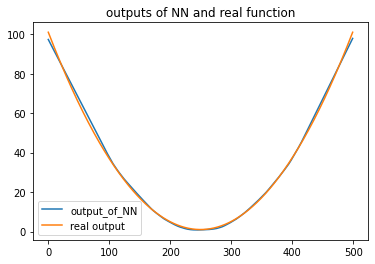

In [45]:
  plt.plot(output_of_NN,label="output_of_NN")
  plt.plot(output,label="real output")
  plt.title("outputs of NN and real function")
  plt.legend()
  plt.show()

#### As it is obvious the MLP model has been modeled very accurate within [-10 , 10]. This is the MLP model of 128 dim hidden layer

In [50]:
new_input=np.linspace(10, 20, 500)
new_input=torch.Tensor([new_input])
new_input=torch.t(new_input)

new_output=F(new_input)
new_output_of_NN=trained_model(new_input)
new_output_of_NN=new_output_of_NN.detach().numpy()

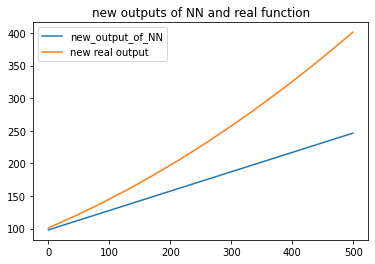

In [51]:
  plt.plot(new_output_of_NN,label="new_output_of_NN")
  plt.plot(new_output,label="new real output")
  plt.title("new outputs of NN and real function")
  plt.legend()
  plt.show()

#### Although the MLP model predict the output very accurate within [-10,10] it is not predincting accuratly the amount outside of [-10,10] and it shows the model has been overfited.